In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

In [2]:
data8 = pd.read_csv('C:/Users/daini/OneDrive/Dators/ai/MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv')

In [3]:
data_combined = data8

# Izvadām datu dimensiju
rows, cols = data_combined.shape
print(f'Number of rows: {rows}, Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

# Noņemam liekās atstarpes no kolonnu nosaukumiem
col_names = {col: col.strip() for col in data_combined.columns}
data_combined.rename(columns = col_names, inplace = True)

data_combined.columns

Number of rows: 692703, Number of columns: 79
Total cells: 54723537


Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [4]:
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             692703 non-null  int64  
 1   Flow Duration                692703 non-null  int64  
 2   Total Fwd Packets            692703 non-null  int64  
 3   Total Backward Packets       692703 non-null  int64  
 4   Total Length of Fwd Packets  692703 non-null  int64  
 5   Total Length of Bwd Packets  692703 non-null  int64  
 6   Fwd Packet Length Max        692703 non-null  int64  
 7   Fwd Packet Length Min        692703 non-null  int64  
 8   Fwd Packet Length Mean       692703 non-null  float64
 9   Fwd Packet Length Std        692703 non-null  float64
 10  Bwd Packet Length Max        692703 non-null  int64  
 11  Bwd Packet Length Min        692703 non-null  int64  
 12  Bwd Packet Length Mean       692703 non-null  float64
 13 

In [5]:
# Daru tīrīšana
# Dublētu vērtību identificēšana
dups = data_combined[data_combined.duplicated()]
print(f'Dublikātu skaits: {len(dups)}')

Dublikātu skaits: 81909


In [6]:
# Noņemam visus dubultos ierakstus
data_combined.drop_duplicates(inplace = True)
data_combined.shape

(610794, 79)

In [7]:
# Trūkstošo vērtību noteikšana
missing_val = data_combined.isna().sum()
print(missing_val.loc[missing_val > 0])

Flow Bytes/s    61
dtype: int64


In [8]:
# Bezgalības vērtību pārbaude
numeric_cols = data_combined.select_dtypes(include = np.number).columns
inf_count = np.isinf(data_combined[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s      241
Flow Packets/s    302
dtype: int64


In [9]:
# Jebkuru bezgalīgu vērtību (pozitīvu vai negatīvu) aizstāšana ar NaN (nevis skaitli)
print(f'Trūkstošās vērtības: {data_combined.isna().sum().sum()}')

data_combined.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Pēc bezgalīgu vērtību apstrādes trūkstošo vērtību skaits: {data_combined.isna().sum().sum()}')

Trūkstošās vērtības: 61
Pēc bezgalīgu vērtību apstrādes trūkstošo vērtību skaits: 604


In [10]:
# Identificējam un saskaitītām trūkstošās vērtības
missing = data_combined.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      302
Flow Packets/s    302
dtype: int64


In [11]:
# Trūkstošo vērtību procentuālās daļas aprēķināšana
mis_per = (missing / len(data_combined)) * 100
print(mis_per[mis_per > 0].round(2))

Flow Bytes/s      0.05
Flow Packets/s    0.05
dtype: float64


In [12]:
# Mediānas noteikšana
med_flow_bytes = data_combined['Flow Bytes/s'].median()
med_flow_packets = data_combined['Flow Packets/s'].median()

# Trūkstošo vērtību aizpildīšana ar mediānu
data_combined['Flow Bytes/s'] = data_combined['Flow Bytes/s'].fillna(med_flow_bytes)
data_combined['Flow Packets/s'] = data_combined['Flow Packets/s'].fillna(med_flow_packets)

print('Trūkstošo \'Flow Bytes/s\' vērtību skaits:', data_combined['Flow Bytes/s'].isna().sum())
print('Trūkstošo \'Flow Packets/s\' vērtību skaits:', data_combined['Flow Packets/s'].isna().sum())

Trūkstošo 'Flow Bytes/s' vērtību skaits: 0
Trūkstošo 'Flow Packets/s' vērtību skaits: 0


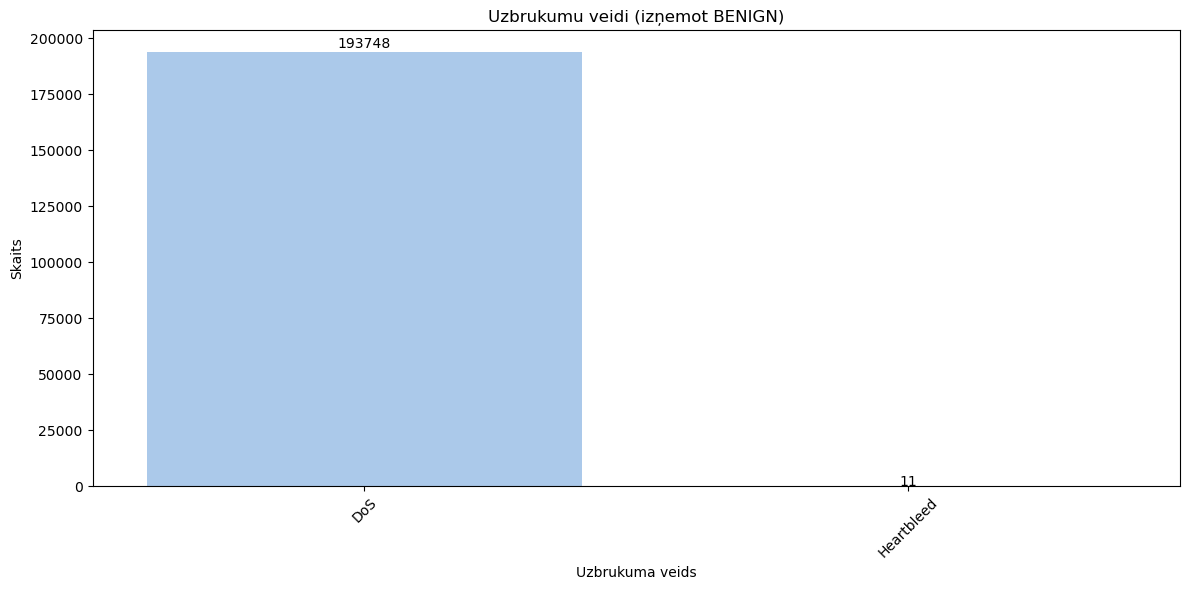

In [13]:
# Izveidojam vārdnīcu, kurā katra uzbrukuma veidi tiek sagrupēti kategorijās
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'Heartbleed': 'Heartbleed'
}

# "Attack Type" definēšana
data_combined['Attack Type'] = data_combined['Label'].map(attack_map)

import matplotlib.pyplot as plt
import seaborn as sns

# Izmantojam visus izņemot "BENIGN"
attacks = data_combined.loc[data_combined['Attack Type'] != 'BENIGN']

plt.figure(figsize=(12, 6))
ax = sns.countplot(
    x='Attack Type',
    hue='Attack Type',
    data=attacks,
    palette='pastel',
    order=attacks['Attack Type'].value_counts().index,
    legend=False
)
plt.title('Uzbrukumu veidi (izņemot BENIGN)')
plt.xlabel('Uzbrukuma veids')
plt.ylabel('Skaits')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height() * 1.01), ha='center')

plt.tight_layout()
plt.show()

In [14]:
# Atdalām iezīmes (X) un mērķa mainīgo (y)
X = data_combined.drop(['Label', 'Attack Type'], axis=1)
y = data_combined['Label']

# Standartizējam datu iezīmes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Vienots KFold sadalītājs visiem modeļiem
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [16]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree modelis
dt = DecisionTreeClassifier(max_depth=6)

dt_scores = cross_validate(dt, X_scaled, y, cv=kf, scoring='accuracy', return_train_score=False)

print(f"Decision Tree vidējais apmācības laiks: {dt_scores['fit_time'].mean():.4f} s")
print(f"Decision Tree vidējais testēšanas laiks: {dt_scores['score_time'].mean():.4f} s")
print(f"Decision Tree kopējais izpildes laiks: {(dt_scores['fit_time'].sum() + dt_scores['score_time'].sum()):.4f} s")
print("-------------------------------")
print(f"Decision Tree 10-fold Cross-Validation Scores: {dt_scores['test_score']}")
print(f"Mean cross-validation accuracy: {dt_scores['test_score'].mean():.4f} ± {dt_scores['test_score'].std():.4f}")

Decision Tree vidējais apmācības laiks: 12.8940 s
Decision Tree vidējais testēšanas laiks: 0.0709 s
Decision Tree kopējais izpildes laiks: 129.6483 s
-------------------------------
Decision Tree 10-fold Cross-Validation Scores: [0.98547806 0.98547806 0.9862148  0.98495416 0.98518312 0.9863783
 0.98554331 0.98600174 0.98642741 0.98506852]
Mean cross-validation accuracy: 0.9857 ± 0.0005


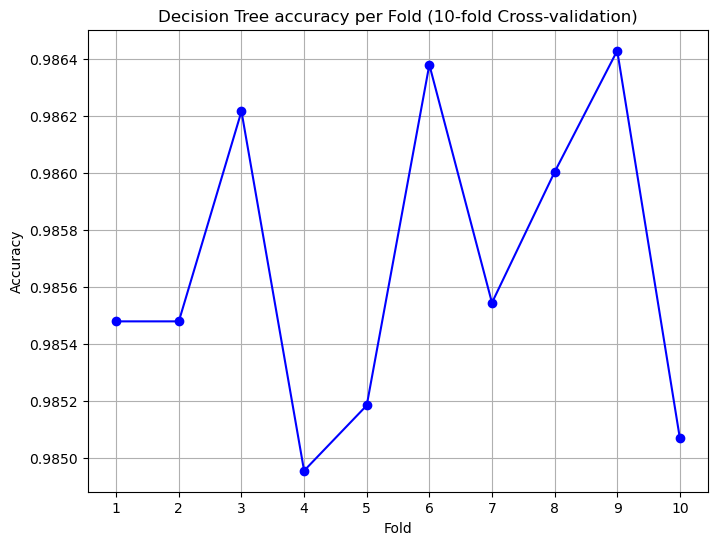

In [17]:
# Latentā precizitāte (katram fold)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), dt_scores['test_score'], marker='o', linestyle='-', color='b')
plt.title('Decision Tree accuracy per Fold (10-fold Cross-validation)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

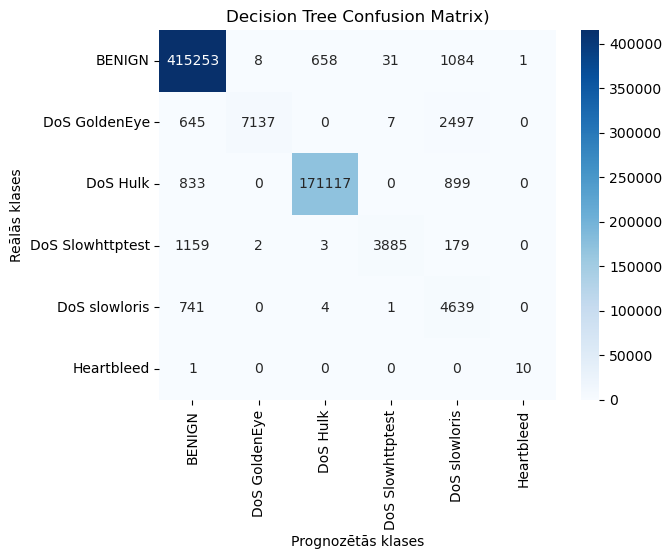

Decision Tree Classification Report:
                  precision    recall  f1-score   support

          BENIGN       0.99      1.00      0.99    417035
   DoS GoldenEye       1.00      0.69      0.82     10286
        DoS Hulk       1.00      0.99      0.99    172849
DoS Slowhttptest       0.99      0.74      0.85      5228
   DoS slowloris       0.50      0.86      0.63      5385
      Heartbleed       0.91      0.91      0.91        11

        accuracy                           0.99    610794
       macro avg       0.90      0.87      0.87    610794
    weighted avg       0.99      0.99      0.99    610794



In [18]:
dt_pred = cross_val_predict(dt, X_scaled, y, cv=kf)

labels = sorted(data_combined['Label'].unique())
# Confusion Matrix
cm_dt = confusion_matrix(y, dt_pred)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Prognozētās klases")
plt.ylabel("Reālās klases")
plt.title("Decision Tree Confusion Matrix)")
plt.show()

# Classification Report
print("Decision Tree Classification Report:")
print(classification_report(y, dt_pred, target_names=labels))

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn_scores = cross_validate(knn, X_scaled, y, cv=kf, scoring='accuracy', return_train_score=False)

print(f"KNN vidējais apmācības laiks: {knn_scores['fit_time'].mean():.4f} s")
print(f"KNN vidējais testēšanas laiks: {knn_scores['score_time'].mean():.4f} s")
print(f"KNN kopējais izpildes laiks: {(knn_scores['fit_time'].sum() + knn_scores['score_time'].sum()):.4f} s")
print("-------------------------------")
print(f"KNN 10-fold Cross-Validation Scores: {knn_scores['test_score']}")
print(f"Mean cross-validation accuracy: {knn_scores['test_score'].mean():.4f} ± {knn_scores['test_score'].std():.4f}")

KNN vidējais apmācības laiks: 0.8803 s
KNN vidējais testēšanas laiks: 47.1863 s
KNN kopējais izpildes laiks: 480.6659 s
-------------------------------
KNN 10-fold Cross-Validation Scores: [0.99888671 0.99890308 0.99878847 0.99864113 0.99875571 0.99883757
 0.9989358  0.99859199 0.99867385 0.99901767]
Mean cross-validation accuracy: 0.9988 ± 0.0001


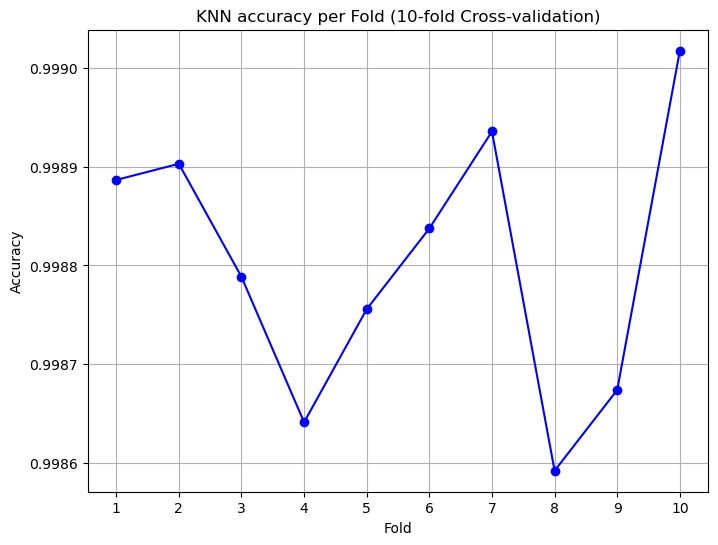

In [20]:
# Latentā precizitāte (katram fold)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), knn_scores['test_score'], marker='o', linestyle='-', color='b')
plt.title('KNN accuracy per Fold (10-fold Cross-validation)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

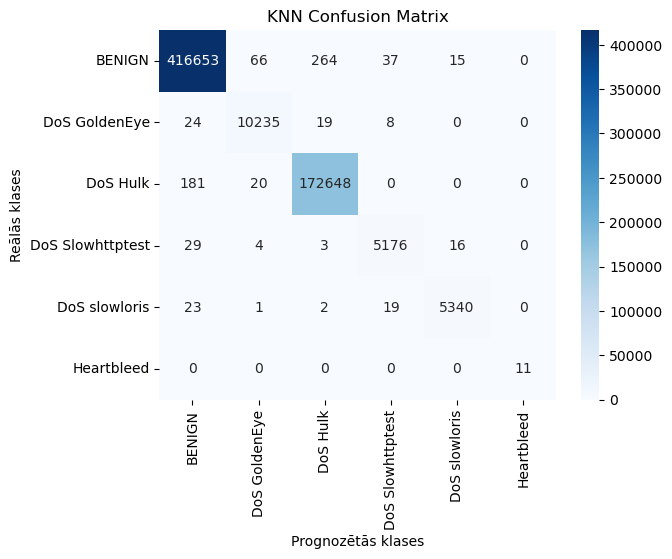

KNN Classification Report:
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    417035
   DoS GoldenEye       0.99      1.00      0.99     10286
        DoS Hulk       1.00      1.00      1.00    172849
DoS Slowhttptest       0.99      0.99      0.99      5228
   DoS slowloris       0.99      0.99      0.99      5385
      Heartbleed       1.00      1.00      1.00        11

        accuracy                           1.00    610794
       macro avg       1.00      1.00      1.00    610794
    weighted avg       1.00      1.00      1.00    610794



In [21]:
knn_pred = cross_val_predict(knn, X_scaled, y, cv=kf)

labels = sorted(data_combined['Label'].unique())
# Confusion Matrix
cm_knn = confusion_matrix(y, knn_pred)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Prognozētās klases")
plt.ylabel("Reālās klases")
plt.title("KNN Confusion Matrix")
plt.show()

# Classification Report
print("KNN Classification Report:")
print(classification_report(y, knn_pred, target_names=labels))

In [22]:
from sklearn.naive_bayes import GaussianNB
# Apmāca Gaussian Naive Bayes modeli
gnb = GaussianNB()

gnb_scores = cross_validate(gnb, X_scaled, y, cv=kf, scoring='accuracy', return_train_score=False)

print(f"Naive Bayes vidējais apmācības laiks: {gnb_scores['fit_time'].mean():.4f} s")
print(f"Naive Bayes vidējais testēšanas laiks: {gnb_scores['score_time'].mean():.4f} s")
print(f"Naive Bayes kopējais izpildes laiks: {(gnb_scores['fit_time'].sum() + gnb_scores['score_time'].sum()):.4f} s")
print("-------------------------------")
print(f"Naive Bayes 10-fold Cross-Validation Scores: {gnb_scores['test_score']}")
print(f"Mean cross-validation accuracy: {gnb_scores['test_score'].mean():.4f} ± {gnb_scores['test_score'].std():.4f}")

Naive Bayes vidējais apmācības laiks: 1.4363 s
Naive Bayes vidējais testēšanas laiks: 0.2949 s
Naive Bayes kopējais izpildes laiks: 17.3120 s
-------------------------------
Naive Bayes 10-fold Cross-Validation Scores: [0.91794368 0.91915521 0.91987557 0.91782908 0.91612502 0.91882644
 0.91953044 0.91715647 0.91736931 0.91664893]
Mean cross-validation accuracy: 0.9180 ± 0.0012


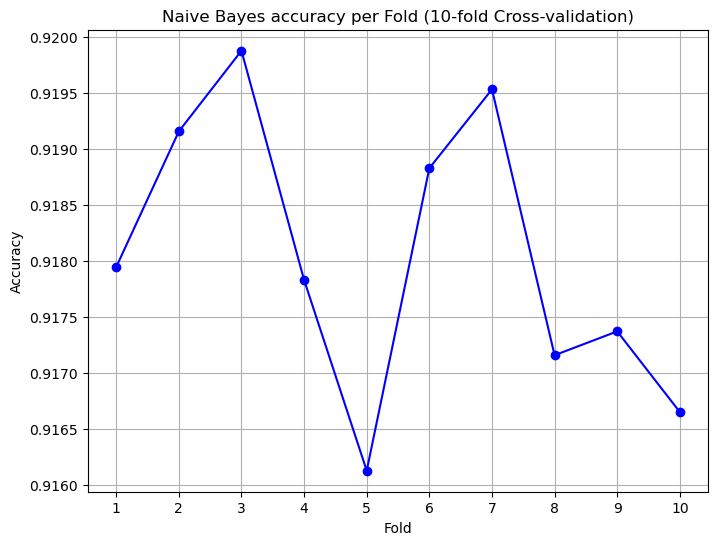

In [23]:
# Latentā precizitāte (katram fold)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), gnb_scores['test_score'], marker='o', linestyle='-', color='b')
plt.title('Naive Bayes accuracy per Fold (10-fold Cross-validation)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

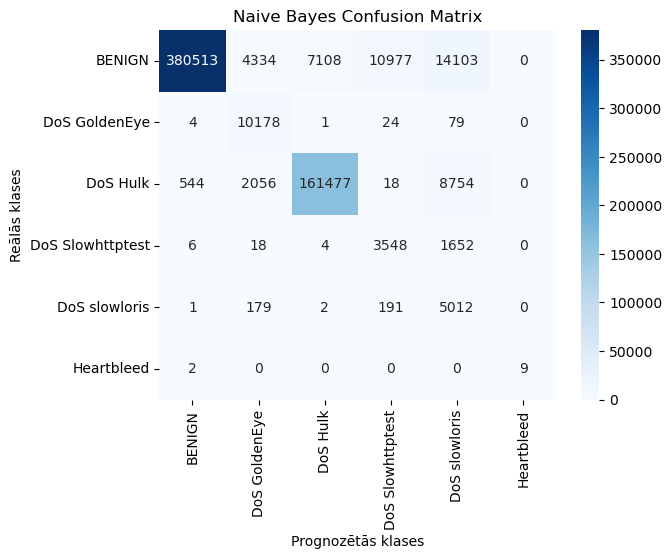

Naive Bayes Classification Report:
                  precision    recall  f1-score   support

          BENIGN       1.00      0.91      0.95    417035
   DoS GoldenEye       0.61      0.99      0.75     10286
        DoS Hulk       0.96      0.93      0.95    172849
DoS Slowhttptest       0.24      0.68      0.36      5228
   DoS slowloris       0.17      0.93      0.29      5385
      Heartbleed       1.00      0.82      0.90        11

        accuracy                           0.92    610794
       macro avg       0.66      0.88      0.70    610794
    weighted avg       0.97      0.92      0.94    610794



In [24]:
gnb_pred = cross_val_predict(gnb, X_scaled, y, cv=kf)

labels = sorted(data_combined['Label'].unique())
# Confusion Matrix
cm_gnb = confusion_matrix(y, gnb_pred)
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Prognozētās klases")
plt.ylabel("Reālās klases")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

# Classification Report
print("Naive Bayes Classification Report:")
print(classification_report(y, gnb_pred, target_names=labels))

In [25]:
# PAMATOJUMS, KĀPĒC F1-score macro avg IR ĻOTI SVARĪGS
accuracy_dt = dt_scores['test_score'].mean() 
accuracy_knn = knn_scores['test_score'].mean() 
accuracy_gnb = gnb_scores['test_score'].mean()

f1_macro_dt = f1_score(y, dt_pred, average='macro')
f1_macro_knn = f1_score(y, knn_pred, average='macro')
f1_macro_gnb = f1_score(y, gnb_pred, average='macro')

percent_difference_dt = ((accuracy_dt - f1_macro_dt) / accuracy_dt) * 100
percent_difference_knn = ((accuracy_knn - f1_macro_knn) / accuracy_knn) * 100
percent_difference_gnb = ((accuracy_gnb - f1_macro_gnb) / accuracy_gnb) * 100

In [26]:
print("Decision Tree Model Comparison")
print("-------------------------------")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"F1 Macro Average: {f1_macro_dt:.4f}")
print(f"Percentage Difference: {percent_difference_dt:.2f}%")

Decision Tree Model Comparison
-------------------------------
Accuracy: 0.9857
F1 Macro Average: 0.8659
Percentage Difference: 12.15%


In [27]:
print("KNN Model Comparison")
print("-------------------------------")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"F1 Macro Average: {f1_macro_knn:.4f}")
print(f"Percentage Difference: {percent_difference_knn:.2f}%")

KNN Model Comparison
-------------------------------
Accuracy: 0.9988
F1 Macro Average: 0.9955
Percentage Difference: 0.33%


In [28]:
print("Naive Bayes Model Comparison")
print("-------------------------------")
print(f"Accuracy: {accuracy_gnb:.4f}")
print(f"F1 Macro Average: {f1_macro_gnb:.4f}")
print(f"Percentage Difference: {percent_difference_gnb:.2f}%")

Naive Bayes Model Comparison
-------------------------------
Accuracy: 0.9180
F1 Macro Average: 0.6989
Percentage Difference: 23.87%
